In [1]:
# imports
from inspect import signature
import control
import numpy
from matplotlib import pyplot as plt
import scipy
import timeit
from ipywidgets import interact, interactive, interact_manual
from IPython.display import display
import ipywidgets as wid

In [2]:
# inputs
def step(t, start, stop):
    if t<start:
        return 0
    else:
        return 1
    #     return numpy.concatenate((numpy.array([0 for i in range(s)]), numpy.array([1 for i in range(l)])), axis=None)


def rect(t, start, drop, stop):
    if t>=start and t<stop:
        return 1
    else:
        return 0
    #     return numpy.concatenate((numpy.array([0 for i in range(s)]), numpy.array([1 for i in range(l)]), numpy.array([0 for i in range(f)])), axis=None)


def doublet(t, start, drop, rise, stop):
    if t>=start and t<drop:
        return 1
    elif t>=drop and t<stop:
        return -1
    else:
        return 0
    #     return numpy.concatenate((numpy.array([0 for i in range(s)]), numpy.array([1 for i in range(l1)]), numpy.array([-1 for i in range(l2)]), numpy.array([0 for i in range(f)])), axis=None)
    
input_dict = {'Step': step, 
              'Rect': rect, 
              'Doublet': doublet}

In [3]:
# read data
def read(file):
    df = pandas.read_csv(file)
    ydata = df.y.values - df.y[0]
    udata = df.u.values - df.u[0]
    tdata = df.t.values
    return [ydata, udata, tdata]

In [4]:
# system

# def FO(u, mv, uv, l):
#     K, tau = mv
#     ts = numpy.linspace(0,l)
#     dt = ts[1]
#     y = 0
#     ys = []
#     for t in ts:
#         dydt = -1/tau*y + 1/tau*u(t, up)
#         y += dydt*dt
#         ys.append(y)
#     return ys

def FO(K, τ):
    return control.tf(K, [τ, 1])

def create_system(Numerator, Denominator):
    return control.tf(Numerator, Denominator)
    
    
    
# -convert to statespace and integrate

system_dict = {'First Order': FO,
              'Create System': create_system}

In [5]:
# Techniques

def DE(function, bounds):
    return scipy.optimize.differential_evolution(function, bounds)
    
tech_dict = {'Differential Evolution': DE}

In [6]:
Y = []
def params(u, i):
    sig = str(signature(u)).split(', ')
    sig[0] = sig[0].split('(')[-1]
    sig[-1] = sig[-1].split(')')[0]
    return sig[i:]
    
def ui():
    names = [names for names,dict in input_dict.items()]
    c_input = input("Choose an input type: {}".format(names))
#     if c_input not in names:
#         while c_input not in names:
#             c_input = input("Ivalid input. Choose an input type from: {}".format(names))
    u = input_dict[c_input]
    u_sig = params(u,1)
    c_input_params = [float(i) for i in input("Input paramter list of format: {}".format(u_sig)).split(', ')]
    
    names = [names for names,dict in system_dict.items()]
    c_system = input("Choose a system type: {}".format(names))
    sys = system_dict[c_system]
    sys_sig = params(sys,0)
    c_sys_params = [float(i) for i in input("Enter the numerator").split(', ')], [float(i) for i in input("Enter the denominator").split(', ')]
#     print(*c_sys_params)
#     c_sys_params = [float(i) for i in (input("Input paramter list of format: {}".format(sys_sig))).split(', ')]

    ts = numpy.linspace(0, c_input_params[-1])
    us = [u(t, *c_input_params) for t in ts]
    system = create_system(*c_sys_params)
    tm, ym, xm = control.forced_response(system, T=ts, U=us)
    plt.plot(tm, ym, 'x', label="Real")
#     print([*c_sys_params])
    
    def err(params):
        num = [params[0]]
        den = params[1:]
        est_sys = control.tf(num, den)
        tsim, ysim, xsim = control.forced_response(est_sys, T=ts, U=us)
        return sum((ym - ysim)**2)
    
    def res(params):
        num = [params[0]]
        den = params[1:]
        est_sys = control.tf(num, den)
        tsim, ysim, xsim = control.forced_response(est_sys, T=ts, U=us)
        plt.plot(tm, ysim, label="Estimation")
        return None

    names = [names for names,dict in tech_dict.items()]
    c_tech = input("Choose an estimation technique: {}".format(names))
    tech = tech_dict[c_tech]
    st = timeit.default_timer()
    coeff = tech(err, [(0.1, 20), (0.1, 20), (0.1, 20)]).x
    et = timeit.default_timer()
    
    print("Parameters estimated as {} in {} seconds".format(coeff/coeff[-1], et-st))
#     print("Time taken: {}".format(et-st))
    res(coeff)
    plt.legend()

In [105]:
interact(sim, 
         input=[names for names,dict in input_dict.items()], 
         system=[names for names,dict in system_dict.items()], 
         technique=[names for names,dict in tech_dict.items()])

interactive(children=(Dropdown(description='input', options=('Step', 'Rect', 'Doublet'), value='Step'), Dropdo…

<function __main__.sim(input='step', system='Create System', technique='Differential Evolution')>

In [104]:
def sim(input='step', system='Create System', technique='Differential Evolution'):
    
    
    
    c_input = input
    u = input_dict[c_input]
    u_sig = u.__code__.co_varnames[1:]
    c_input_params = {}
    c_input_wid = {}
    for var in u_sig:
        c_input_wid[var] = w = wid.IntSlider(value=1, min=0, max=600, description=var, disabled=False)
        display(w)
    
    c_system = system
    sys = system_dict[c_system]
    sys_sig = sys.__code__.co_varnames
    c_sys_params = {}
    c_sys_wid = {}
    for var in sys_sig:
        c_sys_wid[var] = w = wid.Text(value='1', description=var, disabled=False)
        display(w)

    run_sim = wid.Button(description="Run")
    run_est = wid.Button(description="Estimate")
    output = wid.Output()
    
    display(run_sim, output)
    
#     fig = plt.figure()
    fig = plt.figure(0)

    
    def run_sim_clicked(b):
        with output:
            fig.clf()
            for var in u_sig:
                c_input_params[var] = c_input_wid[var].value
            
            for var in sys_sig:
                c_sys_params[var] = [float(i) for i in c_sys_wid[var].value.split(', ')]
            
            ts = numpy.linspace(0, c_input_params['stop'])
            us = [u(t, *c_input_params.values()) for t in ts]
            system = create_system(*c_sys_params.values()) 
            tm, ym, xm = control.forced_response(system, T=ts, U=us)
            
            ax = fig.add_subplot(1,1,1)
            ax.plot(tm, ym, '--', label="Real")
            
#             plt.plot(tm, ym, '--', label="Real")
            ax.legend()
            plt.show()
        
            print("Click")
#             plt.show()
        
    run_sim.on_click(run_sim_clicked)
    
    def err(params):
        num = [params[0]]
        den = params[1:]
        est_sys = control.tf(num, den)
        tsim, ysim, xsim = control.forced_response(est_sys, T=ts, U=us)
        return sum((ym - ysim)**2)
    
    def res(params):
        num = [params[0]]
        den = params[1:]
        est_sys = control.tf(num, den)
        tsim, ysim, xsim = control.forced_response(est_sys, T=ts, U=us)
        plt.plot(tm, ysim, label="Estimation")
        return None

    c_tech = technique
    tech = tech_dict[c_tech]
    st = timeit.default_timer()
#     coeff = tech(err, [(0.1, 20), (0.1, 20), (0.1, 20)]).x
    print("success")
    et = timeit.default_timer()
    
#     print("Parameters estimated as {} in {} seconds".format(coeff/coeff[-1], et-st))
#     print("Time taken: {}".format(et-st))
#     res(coeff)
    

In [84]:
step.__code__.co_varnames[1:]

('start', 'stop')

In [85]:
d = {}
d['test'] = [1,0]
d['test2'] = 2

In [80]:
t = [d[k] for k in d.keys()]
def tt(p1, p2):
    return p1, p2
tt(*t)

([1, 0], 2)

In [81]:

tt(*d.values())

([1, 0], 2)

In [112]:
test3 = '1, 0'.split(', ')
test3

['1', '0']

In [17]:

x_widget = wid.FloatSlider(min=0.0, max=10.0, step=0.05)
y_widget = wid.FloatSlider(min=0.5, max=10.0, step=0.05, value=5.0)

def update_x_range(*args):
    x_widget.max = 2.0 * y_widget.value
y_widget.observe(update_x_range, 'value')

def printer(x, y):
    print(x, y)
interact(printer,x=x_widget, y=y_widget);



interactive(children=(FloatSlider(value=0.0, description='x', max=10.0, step=0.05), FloatSlider(value=5.0, des…

In [ ]:
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)

def on_button_clicked(b):
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)
























[]


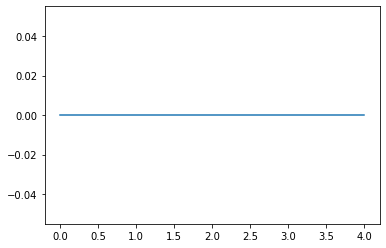

[]


In [109]:
x, y = [0,1,2,3,4], numpy.array([1,1,1,1,1])

for i in range(5):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y)
    plt.close(fig)

print(plt.get_fignums())

fig = plt.figure()
for i in range(5):
    fig.clf()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y*i)
    
    plt.show()

print(plt.get_fignums())